In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tqdm import tqdm
import time
data = pd.read_csv("C:/Users/pengy/Desktop/project1_data.csv")

In [2]:
# 将日期列转换为日期时间格式
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

# 分割数据
train_data = data[data['date'].dt.year < 2013]
test_data = data[data['date'].dt.year >= 2013]
grouped_train_data = train_data.groupby('code')
grouped_test_data = test_data.groupby('code')

In [3]:
# 使用过去多少天的数据
sequence_length = 10
# 选择用于训练的特征列
features = ['open', 'high', 'low', 'close', 'volume']
# 遍历每个分组=
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

x = 0

stock_num = 100

with tqdm(total = stock_num, desc="Progress train", unit="item") as pbar:
    for code, group_df in grouped_train_data:
        x += 1
        # 标准化数据
        scaler = MinMaxScaler()
        group_df[features] = scaler.fit_transform(group_df[features])

        # 准备序列数据
        X_train = []
        for i in range(len(group_df) - sequence_length):
            X_train.append(group_df[features].values[i:i+sequence_length])

        X_train = np.array(X_train)
        y_train = group_df['label'].values[sequence_length:]

        X_train_list.append(X_train)
        y_train_list.append(y_train)
        pbar.update(1)
        if(x == stock_num):
            break

x = 0
with tqdm(total = stock_num, desc="Progress test", unit="item") as pbar:
    for code, group_df in grouped_test_data:
        x += 1
        # 标准化数据
        scaler = MinMaxScaler()
        group_df[features] = scaler.fit_transform(group_df[features])

        # 准备序列数据
        X_test = []
        for i in range(len(group_df) - sequence_length):
            X_test.append(group_df[features].values[i:i+sequence_length])

        X_test = np.array(X_test)
        y_test = group_df['label'].values[sequence_length:]

        X_test_list.append(X_test)
        y_test_list.append(y_test)
        pbar.update(1)
        if(x == stock_num):
            break

Progress test: 100%|██████████| 100/100 [00:04<00:00, 21.84item/s]


In [4]:
X_train_data = np.vstack(X_train_list)
y_train_data = np.concatenate(y_train_list)
print("X_train_data shape:", X_train_data.shape)
print("y_train_data shape:", y_train_data.shape)
X_test_data = np.vstack(X_test_list)
y_test_data = np.concatenate(y_test_list)
print("X_test_data shape:", X_test_data.shape)
print("y_test_data shape:", y_test_data.shape)

X_train_data shape: (67356, 10, 5)
y_train_data shape: (67356,)
X_test_data shape: (21183, 10, 5)
y_test_data shape: (21183,)


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# 假设MyDataset已定义并能正确读取X, y数据
dataset_train = MyDataset(X_train_data, y_train_data)
dataset_test = MyDataset(X_test_data, y_test_data)
# 创建DataLoader实例
batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=True, dropout_rate=0.5):
        super(EnhancedLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate, bidirectional=bidirectional)
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size * (2 if bidirectional else 1), hidden_size), # Adjust input size if bidirectional
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )
        self.layer_norm = nn.LayerNorm(hidden_size * (2 if bidirectional else 1))

    def forward(self, x):
        # 初始化LSTM的hidden state和cell state
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)

        # LSTM前向传播
        out, _ = self.lstm(x, (h0, c0))

        # 应用Layer Normalization
        out = self.layer_norm(out[:, -1, :])

        # 经过全连接层网络
        out = self.fc_layers(out)
        return out


In [7]:
# 定义模型参数
input_size = 5
hidden_size = 8
num_layers = 2
output_size = 2  # 两类，0和1
num_epochs = 4
bidirectional = True  # 使用双向LSTM
dropout_rate = 0.5  # 设置dropout率 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 实例化模型
model = EnhancedLSTMClassifier(input_size, hidden_size, num_layers, output_size, bidirectional, dropout_rate)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)


In [9]:
def train():
    # 用于记录整个训练过程的损失和准确率
    epoch_losses = []
    epoch_accuracies = []
    # 训练模型 
    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0
        for i, (batch_X, batch_y) in enumerate(dataloader_train):
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

            # 每20个batch报告一次
            if (i + 1) % 20 == 0:
                current_loss = total_loss / (i + 1)
                current_accuracy = correct / total
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch {i+1}, Loss: {current_loss:.4f}, Accuracy: {current_accuracy:.4f}')
        
        # 计算每个epoch的平均损失和准确率
        average_loss = total_loss / len(dataloader_train)
        accuracy = correct / total
        epoch_losses.append(average_loss)
        epoch_accuracies.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')
    # 绘制损失和准确率图表
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
    plt.title('Epoch vs Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), epoch_accuracies, marker='o')
    plt.title('Epoch vs Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
def test():
    total_loss = 0.0
    correct = 0
    total = 0

    # 使用model.eval()将模型切换到评估模式
    model.eval()

    with torch.no_grad():  # 禁用梯度计算
        for i, (batch_X, batch_y) in enumerate(dataloader_test):
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    # 计算整个测试集的平均损失和准确率
    average_loss = total_loss / len(dataloader_test)
    accuracy = correct / total

    print(f'Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch [1/4], Batch 20, Loss: 0.7005, Accuracy: 0.5234
Epoch [1/4], Batch 40, Loss: 0.7016, Accuracy: 0.5133
Epoch [1/4], Batch 60, Loss: 0.7018, Accuracy: 0.5016
Epoch [1/4], Batch 80, Loss: 0.7029, Accuracy: 0.4938
Epoch [1/4], Batch 100, Loss: 0.7018, Accuracy: 0.4969
Epoch [1/4], Batch 120, Loss: 0.7000, Accuracy: 0.5034
Epoch [1/4], Batch 140, Loss: 0.6974, Accuracy: 0.5125
Epoch [1/4], Batch 160, Loss: 0.6976, Accuracy: 0.5150
Epoch [1/4], Batch 180, Loss: 0.6970, Accuracy: 0.5165
Epoch [1/4], Batch 200, Loss: 0.6967, Accuracy: 0.5173
Epoch [1/4], Batch 220, Loss: 0.6966, Accuracy: 0.5173
Epoch [1/4], Batch 240, Loss: 0.6964, Accuracy: 0.5164
Epoch [1/4], Batch 260, Loss: 0.6961, Accuracy: 0.5165
Epoch [1/4], Batch 280, Loss: 0.6958, Accuracy: 0.5172
Epoch [1/4], Batch 300, Loss: 0.6955, Accuracy: 0.5177
Epoch [1/4], Batch 320, Loss: 0.6956, Accuracy: 0.5174
Epoch [1/4], Batch 340, Loss: 0.6955, Accuracy: 0.5168
Epoch [1/4], Batch 360, Loss: 0.6956, Accuracy: 0.5170
Epoch [1/4], B

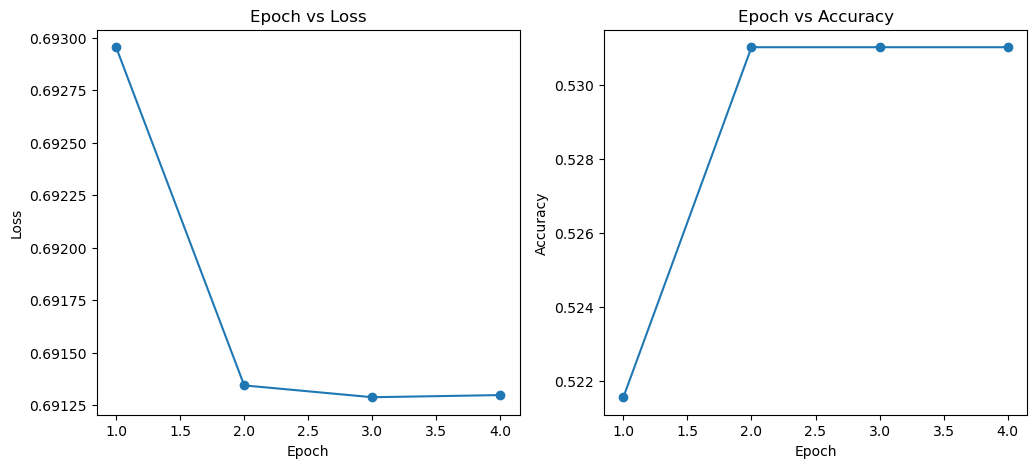

In [10]:
train()

In [12]:
test()

Average Loss: 0.6910, Accuracy: 0.5332
